In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from pca import *


                    mean      variance           std
Eco1        1.608159e+04  3.896715e+08  1.974010e+04
Eco2        1.563012e+04  1.436997e+08  1.198748e+04
Eco3        2.154380e+04  3.392410e+08  1.841850e+04
Energy1     5.190460e+01  5.670438e+02  2.381268e+01
Energy2     8.518011e+01  7.069737e+02  2.658898e+01
Energy3     9.122605e+01  2.653917e+03  5.151618e+01
Health1     2.719460e+01  1.068251e+03  3.268411e+01
Health2     2.639169e+00  1.961718e+00  1.400614e+00
Finan1      4.083050e-01  6.537267e-02  2.556808e-01
Finan2      4.849812e+06  1.299377e+14  1.139902e+07
Finan3      6.034541e-01  8.103563e-02  2.846676e-01
Finan4      2.719485e+00  4.953787e-01  7.038315e-01
Finan5      6.428665e-01  5.486216e-02  2.342267e-01
Governance  2.015184e-01  8.681570e-01  9.317494e-01
Poverty     2.653826e+01  3.945067e+02  1.986219e+01
Env         4.891840e+00  2.955839e+01  5.436763e+00
Other1      5.089391e+00  4.615744e+01  6.793927e+00
Other2      1.497062e+01  2.397513e+02  1.5483

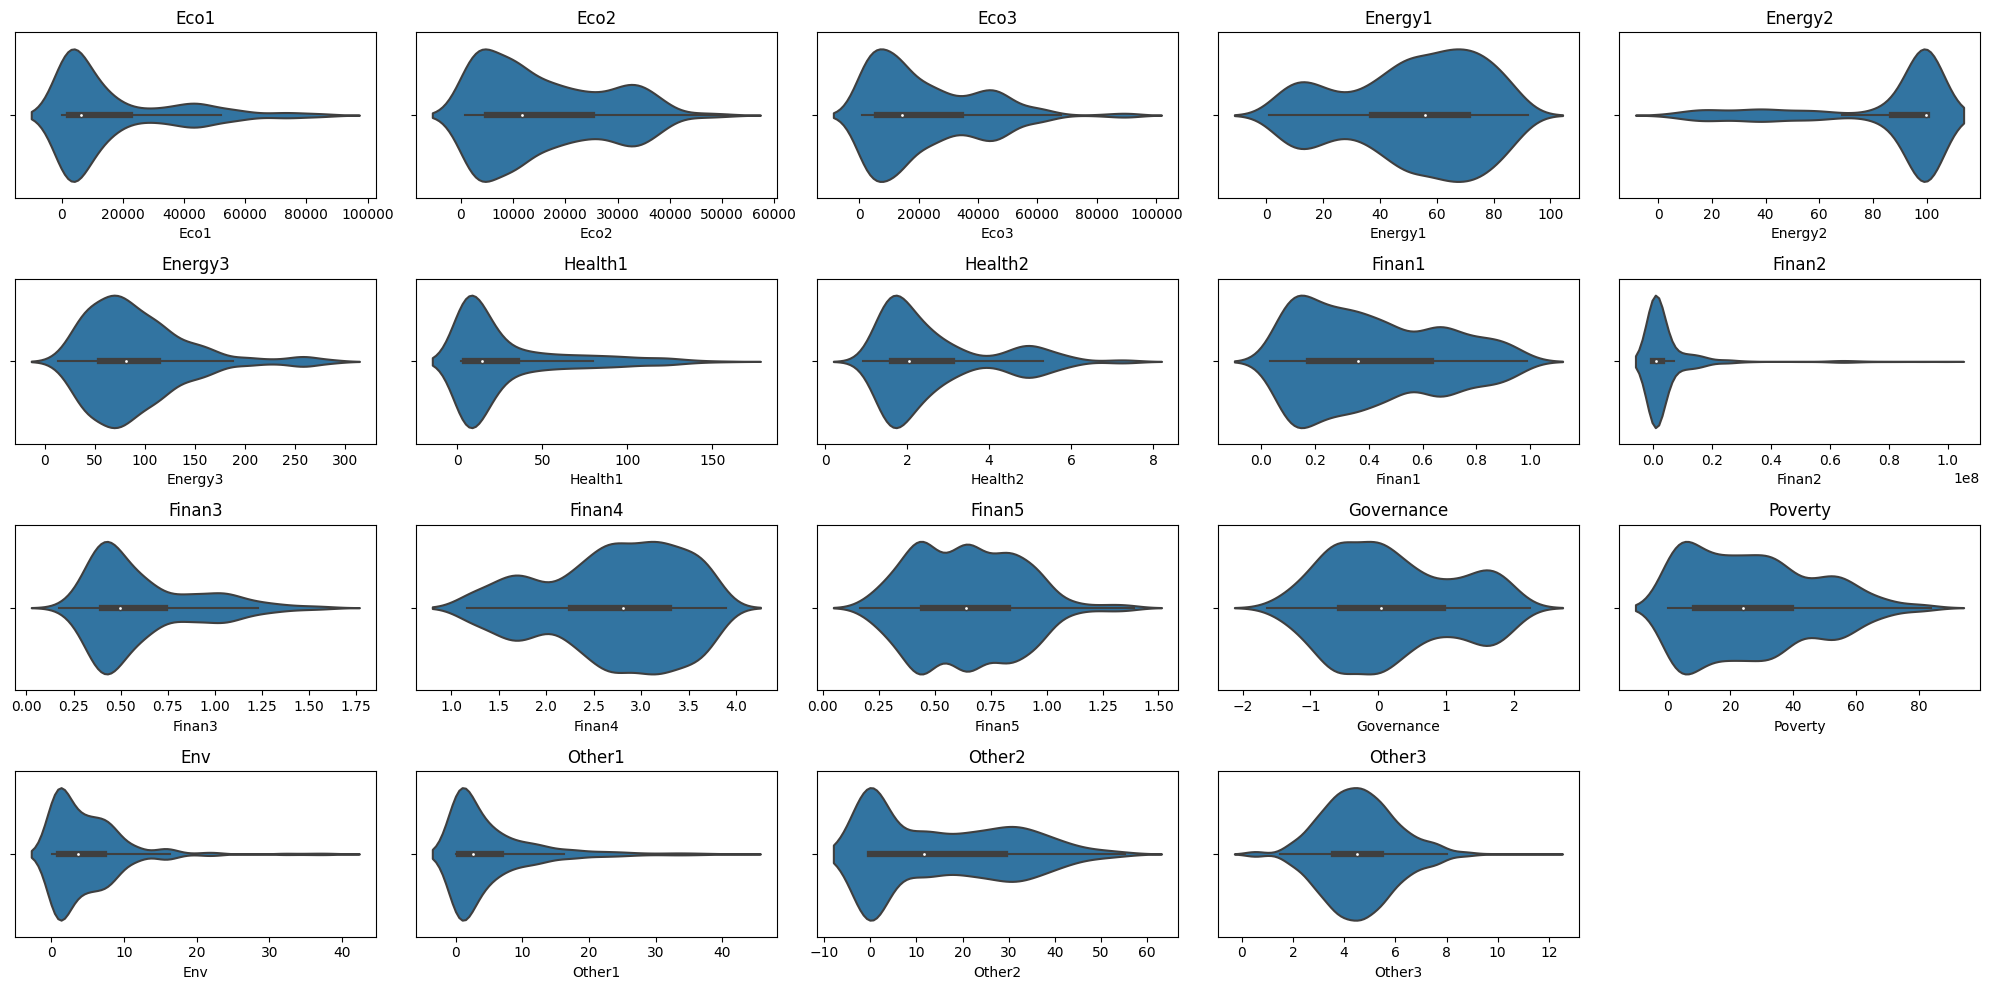

In [2]:
# Load the dataset
file_path = 'Income_Inequality.csv'
data = pd.read_csv(file_path, delimiter=';')
# Compute the descriptive statistics for the quantitative variables
# Exclude 'Country', 'Year', and 'Income_Inequality' columns
quantitative_columns = data.select_dtypes(include=['float64', 'int64']).columns.drop(['Country', 'Year'])
descriptive_stats = data[quantitative_columns].agg(['mean', 'var', 'std']).transpose()
descriptive_stats.rename(columns={'var': 'variance'}, inplace=True)

print(descriptive_stats)

# Check for missing values
missing_values = data[quantitative_columns].isnull().sum()

# Plot violin plots for the quantitative variables
plt.figure(figsize=(20,10))
for i, col in enumerate(quantitative_columns, 1):
    plt.subplot(4, 5, i)
    sns.violinplot(data=data, x=col)
    plt.title(col)

plt.tight_layout()
#plt.show()

In [3]:
# Encode the target variable 'Income_Inequality' where 'H' is 1 and 'L' is 0
label_encoder = LabelEncoder()
data['Income_Inequality'] = label_encoder.fit_transform(data['Income_Inequality'])

# Separate the features and the target
X = data.drop([ 'Country','Year','Income_Inequality'], axis=1)
y = data['Income_Inequality']

# Split the data into a training set and a test set with a test size of 30%
# We use random_state to ensure reproducibility which is equivalent to set.seed in R
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [4]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 100,9),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5),
    'ccp_alpha': [0,0.00001,0.001]  # Add a range for ccp_alpha
}


# Initialize the GridSearchCV object with cross-validation
grid_search = GridSearchCV


# Initialize the GridSearchCV object with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1234), param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# The best hyperparameters from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 2112 candidates, totalling 10560 fits


In [5]:
# Train the model with the best hyperparameters
optimized_tree = grid_search.best_estimator_

# Predict on the test set with the optimized model
y_pred_optimized = optimized_tree.predict(X_test)

# A. Detailed Accuracy By Class
# Calculate the accuracy with the optimized model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
classification_rep_optimized = classification_report(y_test, y_pred_optimized)

print(best_params, best_score, accuracy_optimized, classification_rep_optimized)

# B. Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_optimized)

# C. Additional metrics
# Precision, recall, and f1-scores for each class
precision_class_0 = precision_score(y_test, y_pred_optimized, pos_label=0)
precision_class_1 = precision_score(y_test, y_pred_optimized, pos_label=1)
recall_class_0 = recall_score(y_test, y_pred_optimized, pos_label=0)
recall_class_1 = recall_score(y_test, y_pred_optimized, pos_label=1)
f1_score_class_0 = f1_score(y_test, y_pred_optimized, pos_label=0)
f1_score_class_1 = f1_score(y_test, y_pred_optimized, pos_label=1)

# Compile all the additional metrics into a dictionary for presentation
additional_metrics = {
    'Precision Class 0': precision_class_0,
    'Precision Class 1': precision_class_1,
    'Recall Class 0': recall_class_0,
    'Recall Class 1': recall_class_1,
    'F1 Score Class 0': f1_score_class_0,
    'F1 Score Class 1': f1_score_class_1,
}

print(conf_mat)
print(additional_metrics)

{'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 7} 0.9409158650589351 0.9616858237547893               precision    recall  f1-score   support

           0       0.97      0.98      0.97       171
           1       0.95      0.93      0.94        90

    accuracy                           0.96       261
   macro avg       0.96      0.95      0.96       261
weighted avg       0.96      0.96      0.96       261

[[167   4]
 [  6  84]]
{'Precision Class 0': 0.9653179190751445, 'Precision Class 1': 0.9545454545454546, 'Recall Class 0': 0.9766081871345029, 'Recall Class 1': 0.9333333333333333, 'F1 Score Class 0': 0.9709302325581396, 'F1 Score Class 1': 0.9438202247191012}


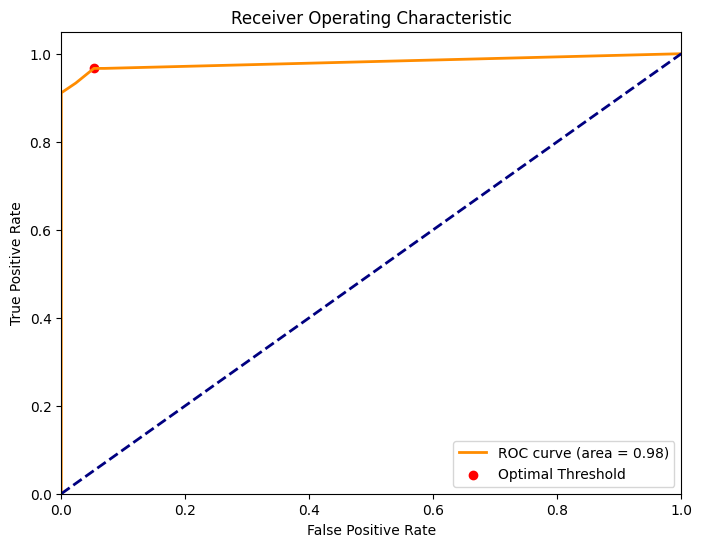

AUC: 0.98
Optimal Threshold: 0.50


In [6]:
# Compute the predicted probabilities of class 1 for the test set
y_pred_prob = optimized_tree.predict_proba(X_test)[:, 1]

# Compute TPR and FPR for various threshold settings
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the AUC
roc_auc = auc(fpr, tpr)

# Calculate the optimal threshold (the one closest to the top-left corner of the ROC space)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Optimal Threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print the AUC and the optimal threshold
print('AUC: %0.2f' % roc_auc)
print('Optimal Threshold: %0.2f' % optimal_threshold)

On observe d'excellents résultats certainement dûs à la rigeur du grid et de la cross validation. Uu tres bon f1 score traduit une performance équilibré pour les differentes classe. La courbe ROC est aussi très encourageante!

Du point de vue de nos données, la classification du pays semble s'expliquer facilement par les données présentes. 

In [7]:
# Obtenez les probabilités prédites de la classe 1 pour l'ensemble de test
y_pred_prob = optimized_tree.predict_proba(X_test)[:, 1]

# Appliquez le seuil optimal pour déterminer les nouvelles étiquettes de classe prédites
y_pred_optimized_threshold = (y_pred_prob >= optimal_threshold).astype(int)
# Recalculez les métriques de performance avec les nouvelles prédictions
accuracy_optimized_threshold = accuracy_score(y_test, y_pred_optimized_threshold)
classification_rep_optimized_threshold = classification_report(y_test, y_pred_optimized_threshold)

# Matrice de confusion mise à jour
conf_mat_optimized_threshold = confusion_matrix(y_test, y_pred_optimized_threshold)

# Métriques supplémentaires mises à jour
precision_class_0_optimized_threshold = precision_score(y_test, y_pred_optimized_threshold, pos_label=0)
precision_class_1_optimized_threshold = precision_score(y_test, y_pred_optimized_threshold, pos_label=1)
recall_class_0_optimized_threshold = recall_score(y_test, y_pred_optimized_threshold, pos_label=0)
recall_class_1_optimized_threshold = recall_score(y_test, y_pred_optimized_threshold, pos_label=1)
f1_score_class_0_optimized_threshold = f1_score(y_test, y_pred_optimized_threshold, pos_label=0)
f1_score_class_1_optimized_threshold = f1_score(y_test, y_pred_optimized_threshold, pos_label=1)

# Recalculate the F1 score with the new threshold
f1_score_optimized_threshold = f1_score(y_test, y_pred_optimized_threshold)

# Display the F1 score with the optimal threshold
print("F1 Score with optimal threshold:", f1_score_optimized_threshold)
# Compilez toutes les métriques supplémentaires dans un dictionnaire pour la présentation
additional_metrics_optimized_threshold = {
    'Precision Class 0': precision_class_0_optimized_threshold,
    'Precision Class 1': precision_class_1_optimized_threshold,
    'Recall Class 0': recall_class_0_optimized_threshold,
    'Recall Class 1': recall_class_1_optimized_threshold,
    'F1 Score Class 0': f1_score_class_0_optimized_threshold,
    'F1 Score Class 1': f1_score_class_1_optimized_threshold,
}

# Afficher les résultats
print("Meilleurs paramètres:", best_params)
print("F1 Score with optimal threshold:", f1_score_optimized_threshold)
print("Précision avec seuil optimal:", accuracy_optimized_threshold)
print("Rapport de classification avec seuil optimal:", classification_rep_optimized_threshold)
print("Matrice de confusion avec seuil optimal:", conf_mat_optimized_threshold)
print("Métriques supplémentaires avec seuil optimal:", additional_metrics_optimized_threshold)

F1 Score with optimal threshold: 0.9354838709677419
Meilleurs paramètres: {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 7}
F1 Score with optimal threshold: 0.9354838709677419
Précision avec seuil optimal: 0.9540229885057471
Rapport de classification avec seuil optimal:               precision    recall  f1-score   support

           0       0.98      0.95      0.96       171
           1       0.91      0.97      0.94        90

    accuracy                           0.95       261
   macro avg       0.94      0.96      0.95       261
weighted avg       0.96      0.95      0.95       261

Matrice de confusion avec seuil optimal: [[162   9]
 [  3  87]]
Métriques supplémentaires avec seuil optimal: {'Precision Class 0': 0.9818181818181818, 'Precision Class 1': 0.90625, 'Recall Class 0': 0.9473684210526315, 'Recall Class 1': 0.9666666666666667, 'F1 Score Class 0': 0.9642857142857142, 'F1 Score Class 1': 0.9354838709677419}


In [8]:
# Initialisation de la forêt d'isolement avec les hyperparamètres spécifiés
iso_forest = IsolationForest(n_estimators=100, random_state=1234)

# Ajustement de la forêt d'isolement à l'ensemble complet des données.
iso_forest.fit(X)

# Calcul des scores d'anomalie pour chaque observation.
anomaly_scores = iso_forest.decision_function(X)

# Ajout des scores d'anomalie au DataFrame original.
data['AnomalyScore'] = anomaly_scores

# Tri des données par les scores d'anomalie pour trouver les plus élevés et les plus bas.
highest_anomalies = data.nlargest(10, 'AnomalyScore')
lowest_anomalies = data.nsmallest(10, 'AnomalyScore')

# Tri des données par les scores d'anomalie pour trouver les plus élevés et les plus bas.
highest_anomaly_scores = data.nlargest(10, 'AnomalyScore')['AnomalyScore']
lowest_anomaly_scores = data.nsmallest(10, 'AnomalyScore')['AnomalyScore']

highest_anomaly_scores, lowest_anomaly_scores

(94     0.118808
 90     0.115175
 95     0.114831
 93     0.114079
 196    0.113981
 195    0.113651
 199    0.112472
 629    0.111926
 198    0.111326
 336    0.110913
 Name: AnomalyScore, dtype: float64,
 671   -0.113272
 672   -0.112261
 673   -0.111429
 670   -0.092140
 674   -0.090403
 675   -0.077090
 0     -0.068277
 677   -0.066479
 573   -0.066351
 571   -0.065978
 Name: AnomalyScore, dtype: float64)

In [9]:
# Charger les données depuis le fichier fourni
file_path = 'Income_Inequality.csv'
data = pd.read_csv(file_path, delimiter=';')

# Encodage de la variable cible 'Income_Inequality' où 'H' est 1 et 'L' est 0
label_encoder = LabelEncoder()
data['Income_Inequality'] = label_encoder.fit_transform(data['Income_Inequality'])

# Séparation des caractéristiques et de la cible
X = data.drop(['Country', 'Year', 'Income_Inequality'], axis=1)
y = data['Income_Inequality']

# Division des données en ensembles d'entraînement et de test avec une taille de test de 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
print(X_train.shape, y_train.shape)
# Calcul des scores d'anomalie pour l'ensemble de données complet
iso_forest = IsolationForest(random_state=1234)
iso_forest.fit(X)

# Calcul des scores d'anomalie pour chaque observation
anomaly_scores = iso_forest.decision_function(X)
data['AnomalyScore'] = anomaly_scores  # Ajout des scores d'anomalie au DataFrame original

# Identification des indices des 50 plus grandes anomalies dans l'ensemble de données complet
top_50_anomalies_indices = data['AnomalyScore'].nsmallest(50).index

# Nous devons maintenant vérifier quels de ces indices appartiennent à l'ensemble d'entraînement
train_indices = X_train.index
top_50_anomalies_train_indices = top_50_anomalies_indices.intersection(train_indices)

# Retrait des 50 plus grandes anomalies des ensembles d'entraînement
X_train = X_train.drop(index=top_50_anomalies_train_indices)
y_train = y_train.drop(index=top_50_anomalies_train_indices)

# Vérification des dimensions après retrait
X_train.shape, y_train.shape, top_50_anomalies_train_indices


(609, 19) (609,)


((572, 19),
 (572,),
 Index([671, 673, 674, 675,   0, 677, 573, 571,  50,   1, 574, 678, 676, 572,
          2, 848, 575, 841,   3, 847, 843, 846,  52, 603, 601, 608, 101, 103,
        141, 561, 720, 142,  54, 102, 600,  53,  56],
       dtype='int64'))

In [10]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 100,9),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5),
    'ccp_alpha': [0,0.00001,0.0001,0.001]  # Add a range for ccp_alpha
}


# Initialize the GridSearchCV object with cross-validation
grid_search = GridSearchCV


# Initialize the GridSearchCV object with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1234), param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# The best hyperparameters from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 2816 candidates, totalling 14080 fits


In [11]:
# Train the model with the best hyperparameters
optimized_tree = grid_search.best_estimator_

# Predict on the test set with the optimized model
y_pred_optimized = optimized_tree.predict(X_test)

# A. Detailed Accuracy By Class
# Calculate the accuracy with the optimized model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
classification_rep_optimized = classification_report(y_test, y_pred_optimized)

print(best_params, best_score, accuracy_optimized, classification_rep_optimized)

# B. Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_optimized)

# C. Additional metrics
# Precision, recall, and f1-scores for each class
precision_class_0 = precision_score(y_test, y_pred_optimized, pos_label=0)
precision_class_1 = precision_score(y_test, y_pred_optimized, pos_label=1)
recall_class_0 = recall_score(y_test, y_pred_optimized, pos_label=0)
recall_class_1 = recall_score(y_test, y_pred_optimized, pos_label=1)
f1_score_class_0 = f1_score(y_test, y_pred_optimized, pos_label=0)
f1_score_class_1 = f1_score(y_test, y_pred_optimized, pos_label=1)

# Compile all the additional metrics into a dictionary for presentation
additional_metrics = {
    'Precision Class 0': precision_class_0,
    'Precision Class 1': precision_class_1,
    'Recall Class 0': recall_class_0,
    'Recall Class 1': recall_class_1,
    'F1 Score Class 0': f1_score_class_0,
    'F1 Score Class 1': f1_score_class_1,
}

print(conf_mat)
print(additional_metrics)

{'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 7} 0.9335621662852784 0.9425287356321839               precision    recall  f1-score   support

           0       0.95      0.96      0.96       171
           1       0.92      0.91      0.92        90

    accuracy                           0.94       261
   macro avg       0.94      0.94      0.94       261
weighted avg       0.94      0.94      0.94       261

[[164   7]
 [  8  82]]
{'Precision Class 0': 0.9534883720930233, 'Precision Class 1': 0.9213483146067416, 'Recall Class 0': 0.9590643274853801, 'Recall Class 1': 0.9111111111111111, 'F1 Score Class 0': 0.9562682215743439, 'F1 Score Class 1': 0.9162011173184358}


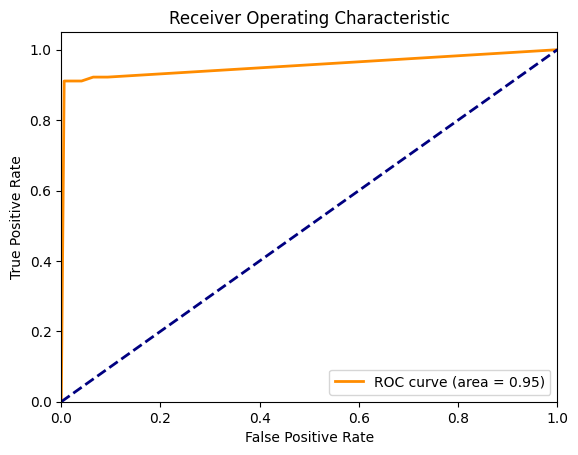

AUC: 0.95


In [12]:
# Compute the predicted probabilities of class 1 for the test set
y_pred_prob = optimized_tree.predict_proba(X_test)[:, 1]

# Compute TPR and FPR for various threshold settings
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print the AUC
print('AUC: %0.2f' % roc_auc)


On observe un résultat similaire à celui obtenu avec l'arbre de décision construit précédemment. Ceux-ci sont tout de même légèrement moins bon, comme le montre la courbe ROC. Il est également plus dur de déterminer le meilleur seuil. 

In [13]:
# Calculer les distances euclidiennes pour chaque point de la courbe ROC par rapport à (0,1)
distances = np.sqrt(fpr**2 + (1 - tpr)**2)

# Trouver l'indice du point avec la distance minimale
min_distance_idx = np.argmin(distances)

# Sélectionner le seuil correspondant à ce point
optimal_threshold = thresholds[min_distance_idx]

# Afficher le seuil optimal
print('Optimal threshold:', optimal_threshold)

# Calculer les probabilités prédites de la classe 1 pour l'ensemble de test
y_pred_prob = optimized_tree.predict_proba(X_test)[:, 1]

# Calculer la distance pour chaque point de la courbe ROC par rapport à (0,1)
distances = np.sqrt(fpr**2 + (1 - tpr)**2)
min_distance_idx = np.argmin(distances)
optimal_threshold = thresholds[min_distance_idx]

# Utiliser le seuil optimal pour obtenir les prédictions finales
y_pred_optimized_threshold = (y_pred_prob >= optimal_threshold).astype(int)

# A. Précision détaillée par classe
accuracy_optimized_threshold = accuracy_score(y_test, y_pred_optimized_threshold)
classification_rep_optimized_threshold = classification_report(y_test, y_pred_optimized_threshold)

# B. Matrice de confusion
conf_mat_optimized_threshold = confusion_matrix(y_test, y_pred_optimized_threshold)

# C. Métriques supplémentaires
precision_class_0_optimized_threshold = precision_score(y_test, y_pred_optimized_threshold, pos_label=0)
precision_class_1_optimized_threshold = precision_score(y_test, y_pred_optimized_threshold, pos_label=1)
recall_class_0_optimized_threshold = recall_score(y_test, y_pred_optimized_threshold, pos_label=0)
recall_class_1_optimized_threshold = recall_score(y_test, y_pred_optimized_threshold, pos_label=1)
f1_score_class_0_optimized_threshold = f1_score(y_test, y_pred_optimized_threshold, pos_label=0)
f1_score_class_1_optimized_threshold = f1_score(y_test, y_pred_optimized_threshold, pos_label=1)
# Recalculate the F1 score with the new threshold
f1_score_optimized_threshold = f1_score(y_test, y_pred_optimized_threshold)

# Compiler toutes les métriques supplémentaires dans un dictionnaire pour présentation
additional_metrics_optimized_threshold = {
    'Precision Class 0': precision_class_0_optimized_threshold,
    'Precision Class 1': precision_class_1_optimized_threshold,
    'Recall Class 0': recall_class_0_optimized_threshold,
    'Recall Class 1': recall_class_1_optimized_threshold,
    'F1 Score Class 0': f1_score_class_0_optimized_threshold,
    'F1 Score Class 1': f1_score_class_1_optimized_threshold,
}

print("F1 Score with optimal threshold:", f1_score_optimized_threshold)
print("Matrice de confusion avec seuil optimal:", conf_mat_optimized_threshold)
print("Métriques supplémentaires avec seuil optimal:", additional_metrics_optimized_threshold)


Optimal threshold: 1.0
F1 Score with optimal threshold: 0.9479768786127168
Matrice de confusion avec seuil optimal: [[170   1]
 [  8  82]]
Métriques supplémentaires avec seuil optimal: {'Precision Class 0': 0.9550561797752809, 'Precision Class 1': 0.9879518072289156, 'Recall Class 0': 0.9941520467836257, 'Recall Class 1': 0.9111111111111111, 'F1 Score Class 0': 0.9742120343839542, 'F1 Score Class 1': 0.9479768786127168}


 La standardisation des données est cruciale car les variables ont des échelles différentes ou des unités de mesure différentes. Si une variable est mesurée à une échelle beaucoup plus grande que les autres, elle dominera la première composante principale et, par conséquent, biaiserait le résultat de l'ACP. La standardisation transforme les données de sorte que chaque variable ait une moyenne de 0 et un écart-type de 1, ce qui permet de traiter toutes les variables de manière égale dans l'analyse.

In [14]:
# Initialisation du StandardScaler
scaler = StandardScaler()

# Standardisation des ensembles d'entraînement et de test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Les données standardisées sont maintenant dans des arrays NumPy, nous pouvons les convertir en DataFrame pour une meilleure lisibilité si nécessaire
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

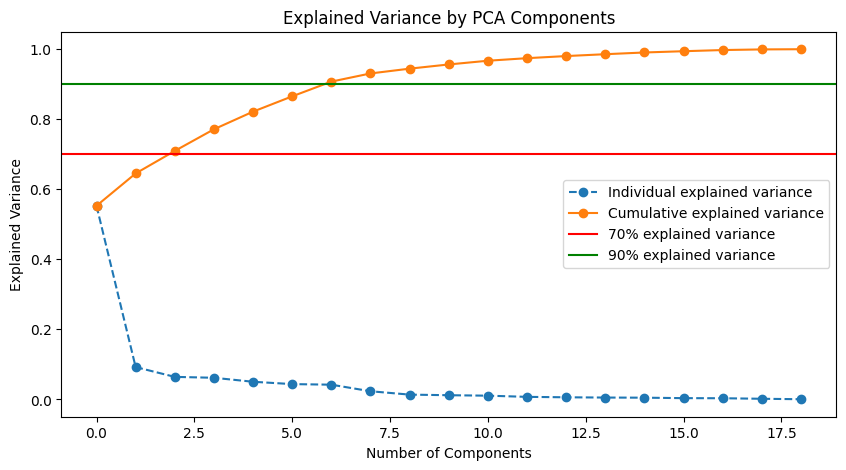

(3, 4, 7)

In [15]:
#X_train_scaled_df is a DataFrame with standardized features
features_scaled = X_train_scaled_df.to_numpy()  # Convert DataFrame to NumPy array if necessary

# Apply PCA
pca = PCA()
components = pca.fit_transform(features_scaled)

# Rule 1: Explained variance is above 0.7 (70%)
explained_variance = pca.explained_variance_ratio()
cumulative_explained_variance = np.cumsum(explained_variance)
k_70 = np.argmax(cumulative_explained_variance >= 0.7) + 1

# Rule 2: Kaiser's rule - eigenvalues greater than 1
kaiser_rule = np.sum(pca.eigenvalues >= 1)

# Rule 3: Explained variance is above 0.9 (90%)
k_90 = np.argmax(cumulative_explained_variance >= 0.9) + 1

# Visualize the explained variance
plt.figure(figsize=(10, 5))
plt.plot(explained_variance, marker='o', linestyle='--', label='Individual explained variance')
plt.plot(cumulative_explained_variance, marker='o', label='Cumulative explained variance')
plt.axhline(y=0.7, color='r', linestyle='-', label='70% explained variance')
plt.axhline(y=0.9, color='g', linestyle='-', label='90% explained variance')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.legend()
plt.show()

# Output the selected dimensions
k_70, kaiser_rule, k_90


c:\Users\decroux paul\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


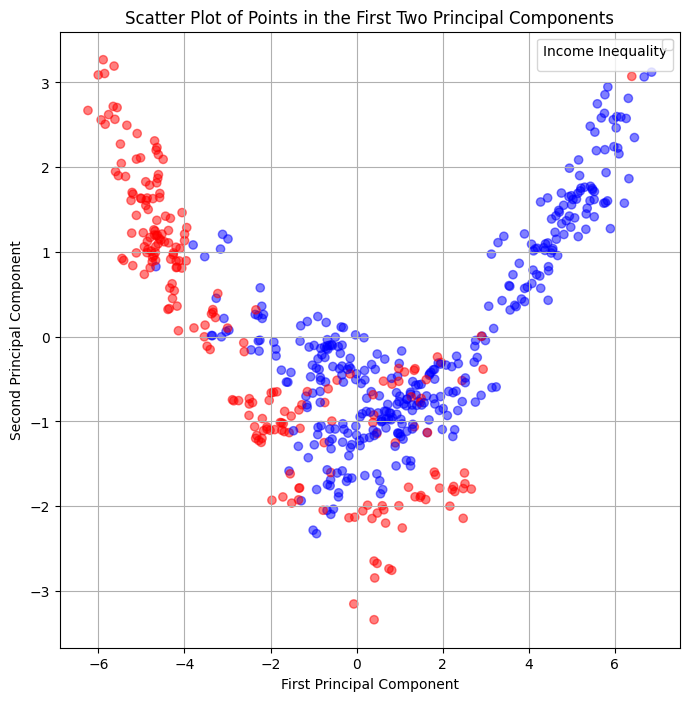

In [16]:
# Initialize PCA and fit to the scaled training data
pca = PCA()
pca.fit(X_train_scaled)

# Determine the number of components for 70% explained variance
explained_variance = pca.explained_variance_ratio()
cumulative_explained_variance = np.cumsum(explained_variance)
k_70 = np.argmax(cumulative_explained_variance >= 0.7) + 1

# Select the first k_70 components
components_k_70 = pca.transform(X_train_scaled)[:, :k_70]

# Assuming y_train is a pandas Series with the same index as X_train_scaled
# Map the binary classes to colors
class_colors = y_train.map({1: 'red', 0: 'blue'})

# Visualize the scatter plot of the first two principal components
plt.figure(figsize=(8, 8))
scatter = plt.scatter(components_k_70[:, 0], components_k_70[:, 1], c=class_colors, alpha=0.5)
plt.title('Scatter Plot of Points in the First Two Principal Components')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True)

# Create a legend
legend1 = plt.legend(*scatter.legend_elements(), title="Income Inequality")
plt.gca().add_artist(legend1)
plt.legend(handles=scatter.legend_elements()[0], labels=['High Inequality (1)', 'Low Inequality (0)'])
plt.show()


On peut distinguer sur ce graphe,une séparation géographique entre les points rouges et bleus, ce qui suggère que notre ACP est capable de déterminer la classe H ou L d'une donnée, en regardant sa projection. 

In [17]:
test_indices = X_test.index

# Transformer les données de test avec PCA pour obtenir toutes les composantes principales.
X_test_projected_all = pca.transform(X_test_scaled)

# Calculer les distances au carré par rapport à l'origine pour chaque point projeté avec toutes les composantes.
squared_distances_all = np.sum(X_test_projected_all**2, axis=1)

# Trouver les indices des 10 individus les plus mal projetés avec toutes les composantes.
indices_worst_projected_all_positions = np.argsort(squared_distances_all)[-10:]
# Mapper les positions relatives aux indices originaux dans le jeu de données de test.
indices_worst_projected_all = test_indices[indices_worst_projected_all_positions].tolist()

# Répéter pour les 6 composantes principales.
X_test_projected_6 = pca.transform(X_test_scaled)[:, :6]
squared_distances_6 = np.sum(X_test_projected_6**2, axis=1)
indices_worst_projected_6_positions = np.argsort(squared_distances_6)[-10:]
indices_worst_projected_6 = test_indices[indices_worst_projected_6_positions].tolist()

# Trouver les indices originaux des 50 pires anomalies dans l'ensemble de test.
top_50_anomalies_test_indices = set(top_50_anomalies_indices).intersection(set(test_indices))

# Afficher les résultats.
print("Indices originaux des 10 individus les plus mal projetés avec toutes les composantes:", indices_worst_projected_all)
print("Indices originaux des 10 individus les plus mal projetés avec 6 composantes:", indices_worst_projected_6)
print("Indices originaux des 50 pires anomalies dans l'ensemble de test:", top_50_anomalies_test_indices)


Indices originaux des 10 individus les plus mal projetés avec toutes les composantes: [166, 842, 840, 844, 845, 679, 849, 670, 169, 672]
Indices originaux des 10 individus les plus mal projetés avec 6 composantes: [51, 166, 840, 842, 844, 845, 849, 670, 169, 672]
Indices originaux des 50 pires anomalies dans l'ensemble de test: {672, 576, 679, 8, 840, 842, 844, 845, 849, 51, 602, 570, 670}


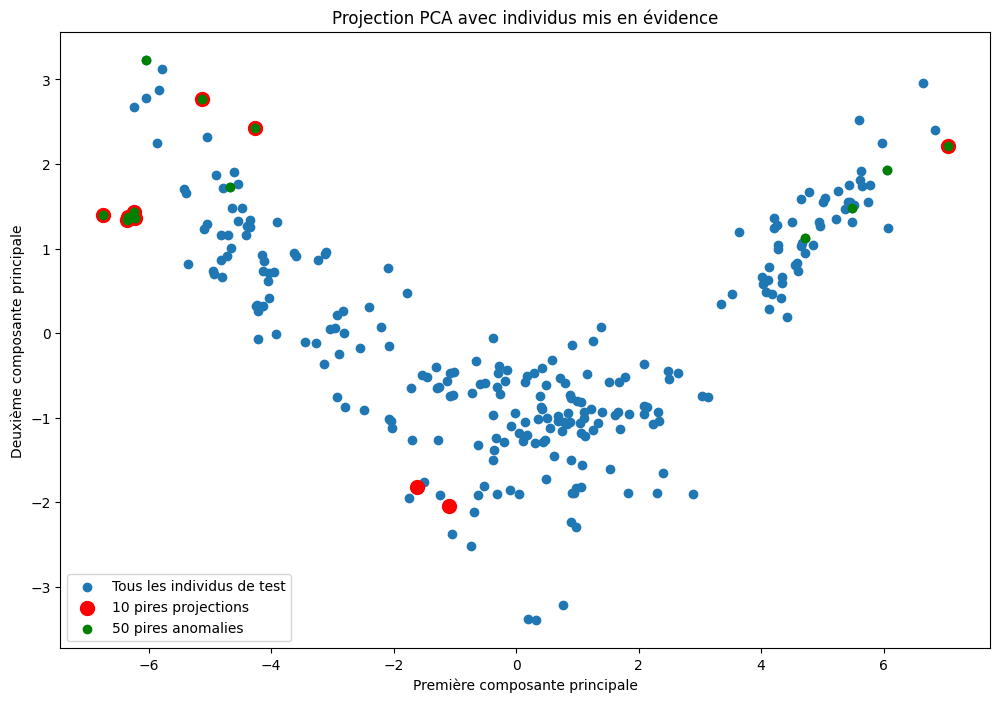

In [18]:

# Project the test data onto the first two principal components for 2D visualization.
X_test_projected_2d = pca.transform(X_test_scaled)[:, :2]

# Convertir les indices originaux en positions pour la visualisation.
indices_worst_projected_6_positions = [test_indices.get_loc(index) for index in indices_worst_projected_6]
top_50_anomalies_positions = [test_indices.get_loc(index) for index in top_50_anomalies_test_indices]

# Créer le graphique 2D.
plt.figure(figsize=(12, 8))
plt.scatter(X_test_projected_2d[:, 0], X_test_projected_2d[:, 1], label='Tous les individus de test')

# Mettre en évidence les 10 individus les plus mal projetés.
plt.scatter(X_test_projected_2d[indices_worst_projected_6_positions, 0],
            X_test_projected_2d[indices_worst_projected_6_positions, 1],
            color='red', s=100,  label='10 pires projections')

# Mettre en évidence les 50 pires anomalies.
plt.scatter(X_test_projected_2d[top_50_anomalies_positions, 0],
            X_test_projected_2d[top_50_anomalies_positions, 1],
            color='green', label='50 pires anomalies')

# Ajouter des légendes et des étiquettes.
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.legend()
plt.title('Projection PCA avec individus mis en évidence')
plt.show()

On arrive bel et bien à discriminer les individus qui sont mal représentés, ce qui correspond aux faux négatifs et faux positifs. 

In [19]:
# X_train_scaled_df is a pandas DataFrame of the scaled features

# Define the number of bins for discretization
num_bins = 10

# Initialize a dictionary to hold the 2D contingency tables for each pair of features
contingency_tables = {}

# Loop over each pair of columns and compute the contingency table
for i in range(len(X_train_scaled_df.columns)):
    for j in range(i + 1, len(X_train_scaled_df.columns)):
        col1, col2 = X_train_scaled_df.columns[i], X_train_scaled_df.columns[j]
        
        # Get bin edges for each feature based on its own distribution
        bin_edges_col1 = pd.qcut(X_train_scaled_df[col1], q=num_bins, retbins=True, duplicates='drop')[1]
        bin_edges_col2 = pd.qcut(X_train_scaled_df[col2], q=num_bins, retbins=True, duplicates='drop')[1]
        
        # Discretize each feature using its own bin edges
        binned_col1 = pd.cut(X_train_scaled_df[col1], bins=bin_edges_col1, include_lowest=True, labels=False)
        binned_col2 = pd.cut(X_train_scaled_df[col2], bins=bin_edges_col2, include_lowest=True, labels=False)
        
        # Compute the contingency table for the pair (col1, col2)
        contingency_table = pd.crosstab(binned_col1, binned_col2)
        
        # Store the contingency table in the dictionary with a tuple key of the feature names
        contingency_tables[(col1, col2)] = contingency_table

# Display an example contingency table for the first pair of features
first_pair = list(contingency_tables.keys())[0]
print(contingency_tables[first_pair])

# Retrieve the first pair's contingency table from the dictionary
first_pair_contingency_table = contingency_tables[first_pair]

# Perform the sum of the contingency table values
contingency_table_sum = first_pair_contingency_table.values.sum()
print(len(X_train_scaled))
print(contingency_table_sum)
# Normalize the contingency table by dividing by the sum of all its values
normalized_contingency_table = first_pair_contingency_table / contingency_table_sum

# Round the normalized contingency table to four decimal places
rounded_normalized_contingency_table = normalized_contingency_table.round(3)

print(f"Normalized Contingency Table for {first_pair}, rounded to 4 decimal places:")
print(rounded_normalized_contingency_table)

Eco2   0   1   2   3   4   5   6   7   8   9
Eco1                                        
0     52   5   1   0   0   0   0   0   0   0
1      6  42   9   0   0   0   0   0   0   0
2      0  10  36   5   5   1   0   0   0   0
3      0   0   7  23  26   1   0   0   0   0
4      0   0   1  25  20  11   0   0   0   0
5      0   0   3   4   6  30  11   3   0   0
6      0   0   0   0   0  13  39   5   0   0
7      0   0   0   0   0   1   7  45   4   0
8      0   0   0   0   0   0   0   3  37  17
9      0   0   0   0   0   0   0   1  16  41
572
572
Normalized Contingency Table for ('Eco1', 'Eco2'), rounded to 4 decimal places:
Eco2      0      1      2      3      4      5      6      7      8      9
Eco1                                                                      
0     0.091  0.009  0.002  0.000  0.000  0.000  0.000  0.000  0.000  0.000
1     0.010  0.073  0.016  0.000  0.000  0.000  0.000  0.000  0.000  0.000
2     0.000  0.017  0.063  0.009  0.009  0.002  0.000  0.000  0.000  0.0

In [ ]:
print(len(X_train_scaled))

In [20]:
# We will calculate the matrices V, B, and W manually from the covariance matrix

# Compute the covariance matrix of the standardized data
cov_matrix = np.cov(X_train_scaled.T)

# Compute the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort the eigenvalues and eigenvectors by decreasing eigenvalues
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Compute the matrix V (eigenvectors sorted)
V_manual = sorted_eigenvectors

# Compute the matrix B (sqrt of eigenvalues in diagonal matrix form)
B_manual = np.diag(np.sqrt(sorted_eigenvalues))

# Compute the matrix W (X_train_scaled projected onto the eigenvectors)
W_manual = np.dot(X_train_scaled, V_manual)

# Output the matrices
V_manual, B_manual, W_manual[:5]  # Displaying only the first 5 rows of W for brevity


(array([[-0.26105022,  0.35290367, -0.03625673,  0.00784306,  0.00089975,
         -0.08374949,  0.01770511,  0.01967175,  0.21933791,  0.18450066,
         -0.03317467, -0.15036205, -0.08835905, -0.12585229,  0.35199423,
          0.12745137, -0.37219856,  0.50191127,  0.37165167],
        [-0.2935998 ,  0.17325747, -0.0336651 , -0.02890714,  0.08242503,
         -0.04768346,  0.05409378,  0.03124234,  0.02166663,  0.02266234,
         -0.09146855, -0.05186841, -0.06391975, -0.01351925,  0.16500163,
         -0.12989908,  0.18817693, -0.68919656,  0.54592318],
        [-0.28829946,  0.2109756 , -0.01329187, -0.03950736,  0.09607271,
         -0.04045185,  0.0512508 ,  0.0217922 ,  0.06114163,  0.0356406 ,
         -0.10914156, -0.16989703, -0.1632249 , -0.02437339,  0.3765251 ,
         -0.02207176, -0.16971649, -0.28576387, -0.72864428],
        [-0.26331947, -0.18957078,  0.14046182,  0.06805914, -0.00647471,
         -0.16426981, -0.04747128, -0.12315452,  0.07146075, -0.428203  ,


In [21]:
# Calculate the inverse of the covariance matrix
cov_matrix_inv = np.linalg.inv(cov_matrix)

# Now we calculate the product of the inverse covariance matrix and B (which is diagonal matrix of eigenvalues)
product_matrix = np.dot(cov_matrix_inv, B_manual)

# Find the eigenvalues and eigenvectors of this product matrix
eigenvalues_U, eigenvectors_U = np.linalg.eig(product_matrix)

# Project the individuals (observations) onto the new space defined by the eigenvectors U
# We use the standardized data X_train_scaled for this projection
projection_U = np.dot(X_train_scaled, eigenvectors_U)

eigenvalues_U, eigenvectors_U, projection_U[:5]  # Displaying only the first 5 projections for brevity

(array([1.46029315e+02, 4.95702145e+01, 1.50504612e+01, 1.08645481e+01,
        9.56307432e+00, 5.90542167e+00, 4.45112640e+00, 3.14815404e+00,
        2.66993133e+00, 2.01206359e+00, 1.22977944e+00, 9.56295716e-01,
        7.47650741e-01, 4.64766254e-02, 4.39515953e-01, 3.83381925e-01,
        1.08410239e-01, 2.65596026e-01, 2.17486193e-01]),
 array([[-4.52311827e-01, -4.27209507e-01,  1.67426437e-01,
         -1.72851017e-02, -1.22349092e-01, -3.22580070e-02,
         -2.23946687e-02,  1.03570177e-02,  4.36474291e-03,
          3.08143792e-02, -2.91792840e-02, -7.87501226e-03,
          1.37625766e-02,  3.05585001e-02, -9.88783474e-03,
         -5.54025314e-02, -1.34035503e-03, -2.95854589e-03,
         -4.59478130e-03],
        [-4.66211357e-01,  8.59718412e-01,  1.42719463e-01,
          1.15685292e-02, -2.58532260e-01, -1.02550777e-01,
         -5.38242637e-02,  1.08354106e-03, -1.37867692e-02,
          3.01226727e-02, -3.62304570e-02, -4.87176602e-04,
          2.63587425e-02,  

In [22]:
# Calculate the explained variance for each principal component
explained_variance_ratio = eigenvalues_U / np.sum(eigenvalues_U)

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Determine the number of components to retain to explain at least 90% of the variance
k = np.argmax(cumulative_explained_variance >= 0.9) + 1  # Add 1 because indices are 0-based

k, cumulative_explained_variance[k-1]  # k and the exact cumulative variance explained by the first k components

(5, 0.9109777359106652)

In [23]:
# Transformer les données de test avec AFD pour obtenir toutes les composantes principales.
X_test_projected_all = np.dot(X_test_scaled - scaler.mean_, eigenvectors_U)
# Calculer les distances au carré par rapport à l'origine pour chaque point projeté avec toutes les composantes.
squared_distances_all = np.sum(X_test_projected_all**2, axis=1)

# Trouver les indices des 10 individus les plus mal projetés avec toutes les composantes.
indices_worst_projected_all_positions = np.argsort(squared_distances_all)[-10:]
# Mapper les positions relatives aux indices originaux dans le jeu de données de test.
indices_worst_projected_all = test_indices[indices_worst_projected_all_positions].tolist()

# Répéter pour les k composantes principales sélectionnées par le critère des 90% de variance expliquée.
k = 5  # Nombre de composantes à retenir déterminé par le critère de variance expliquée
X_test_projected_k = np.dot(X_test_scaled - scaler.mean_, eigenvectors_U[:, :k])
squared_distances_k = np.sum(X_test_projected_k**2, axis=1)
indices_worst_projected_k_positions = np.argsort(squared_distances_k)[-10:]
indices_worst_projected_k = test_indices[indices_worst_projected_k_positions].tolist()

# Afficher les résultats.
print("Indices originaux des 10 individus les plus mal projetés avec toutes les composantes:", sorted(indices_worst_projected_all))
print(f"Indices originaux des 10 individus les plus mal projetés avec {k} composantes:", sorted(indices_worst_projected_k))
print("Indices originaux des 50 pires anomalies dans l'ensemble de test:", top_50_anomalies_test_indices)


Indices originaux des 10 individus les plus mal projetés avec toutes les composantes: [28, 29, 100, 104, 426, 428, 449, 480, 614, 672]
Indices originaux des 10 individus les plus mal projetés avec 5 composantes: [420, 422, 423, 426, 428, 496, 498, 576, 578, 579]
Indices originaux des 50 pires anomalies dans l'ensemble de test: {672, 576, 679, 8, 840, 842, 844, 845, 849, 51, 602, 570, 670}


[166, 842, 840, 844, 845, 679, 849, 670, 169, 672] étaient les 10 individus les plus mal projetés pour l'ACP. On remarque donc des différences au niveau de la projection entre l'ACP et l'AFD.

Indices originaux des 10 individus les plus mal projetés avec toutes les composantes: [28, 29, 100, 104, 426, 428, 449, 480, 614, 672]
Indices originaux des 10 individus les plus mal projetés avec 5 composantes: [420, 422, 423, 426, 428, 496, 498, 576, 578, 579]
Indices originaux des 50 pires anomalies dans l'ensemble de test: {672, 576, 679, 8, 840, 842, 844, 845, 849, 51, 602, 570, 670}


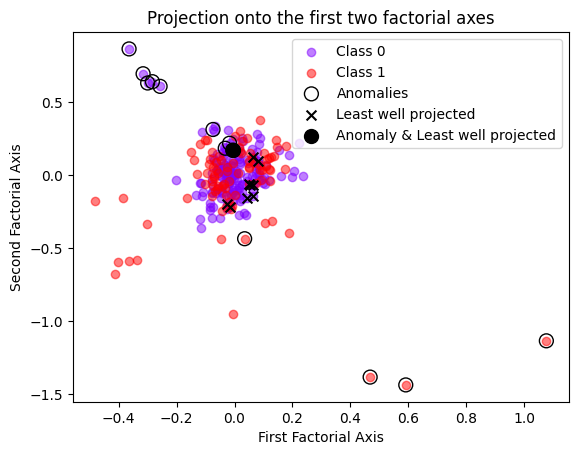

In [24]:
# Transformer les données de test avec AFD pour obtenir toutes les composantes principales.
X_test_projected_all = np.dot(X_test_scaled - scaler.mean_, eigenvectors_U)
# Calculer les distances au carré par rapport à l'origine pour chaque point projeté avec toutes les composantes.
squared_distances_all = np.sum(X_test_projected_all**2, axis=1)

# Trouver les indices des 10 individus les plus mal projetés avec toutes les composantes.
indices_worst_projected_all_positions = np.argsort(squared_distances_all)[-10:]
# Mapper les positions relatives aux indices originaux dans le jeu de données de test.
indices_worst_projected_all = test_indices[indices_worst_projected_all_positions].tolist()

# Répéter pour les k composantes principales sélectionnées par le critère des 90% de variance expliquée.
k = 5  # Nombre de composantes à retenir déterminé par le critère de variance expliquée
X_test_projected_k = np.dot(X_test_scaled - scaler.mean_, eigenvectors_U[:, :k])
squared_distances_k = np.sum(X_test_projected_k**2, axis=1)
indices_worst_projected_k_positions = np.argsort(squared_distances_k)[-10:]
indices_worst_projected_k = test_indices[indices_worst_projected_k_positions].tolist()

# Afficher les résultats.
print("Indices originaux des 10 individus les plus mal projetés avec toutes les composantes:", sorted(indices_worst_projected_all))
print(f"Indices originaux des 10 individus les plus mal projetés avec {k} composantes:", sorted(indices_worst_projected_k))
print("Indices originaux des 50 pires anomalies dans l'ensemble de test:", top_50_anomalies_test_indices)

# 'projection_U' est la projection des données sur les axes de l'AFD
# et 'y_test' contient les étiquettes de classe correspondantes.
projection_U = np.dot(X_test_scaled, eigenvectors_U)

# Sélectionnez les deux premiers axes factoriels pour l'ensemble de test
X_test_projected_2d = projection_U[:, :2]

# Créer un nuage de points avec une couleur pour chaque classe
class_labels = np.unique(y_test)  # Les étiquettes de classe uniques
colors = plt.cm.rainbow(np.linspace(0, 1, len(class_labels)))  # Un tableau de couleurs

# Tracez tous les points avec leur couleur de classe correspondante
for label, color in zip(class_labels, colors):
    plt.scatter(
        X_test_projected_2d[y_test == label, 0],  # Coordonnées sur le premier axe
        X_test_projected_2d[y_test == label, 1],  # Coordonnées sur le deuxième axe
        label=f'Class {label}',
        color=color,
        alpha=0.5  # Rendre les points légèrement transparents pour distinguer les superpositions
    )

# Obtenir les indices relatifs pour les anomalies dans l'ensemble de test
top_50_anomalies_test_relative_indices = [i for i, idx in enumerate(X_test.index) if idx in top_50_anomalies_indices]

# Obtenir les indices relatifs pour les points les moins bien projetés dans l'ensemble de test
indices_worst_projected_k_relative = [i for i, idx in enumerate(X_test.index) if idx in indices_worst_projected_k]

# Entourez les anomalies avec des cercles plus grands
for index in top_50_anomalies_test_relative_indices:
    plt.scatter(
        X_test_projected_2d[index, 0],
        X_test_projected_2d[index, 1],
        facecolors='none',  # Pas de remplissage
        edgecolors='black',  # Couleur du contour
        s=100,  # Taille du contour plus grande
        label='Anomalies' if 'Anomalies' not in plt.gca().get_legend_handles_labels()[1] else ""
    )

# Marquez les points les moins bien projetés avec des croix
for index in indices_worst_projected_k_relative :
    plt.scatter(
        X_test_projected_2d[index, 0],
        X_test_projected_2d[index, 1],
        color='black',  # Couleur des croix
        marker='x',  # Forme de croix
        s=50,  # Taille des croix
        label='Least well projected' if 'Least well projected' not in plt.gca().get_legend_handles_labels()[1] else ""
    )

# Ensuite, pour chaque point qui est à la fois une anomalie et un point mal projeté, faites les deux visualisations.
for index in top_50_anomalies_test_relative_indices:
    if index in indices_worst_projected_k_relative :
        plt.scatter(
            X_test_projected_2d[index, 0],
            X_test_projected_2d[index, 1],
            facecolors='black',  # Pas de remplissage
            edgecolors='black',  # Couleur du contour
            s=100,  # Taille du contour plus grande
            label='Anomaly & Least well projected' if 'Anomaly & Least well projected' not in plt.gca().get_legend_handles_labels()[1] else ""
        )


# Ajouter des légendes et des étiquettes
plt.xlabel('First Factorial Axis')
plt.ylabel('Second Factorial Axis')
plt.legend()
plt.title('Projection onto the first two factorial axes')
plt.show()

In [25]:
# mise en place des nouvelles valuers de train et test
X_train=np.dot(X_train_scaled, eigenvectors_U)[:, :5]
X_test=np.dot(X_test_scaled, eigenvectors_U)[:, :5]

In [27]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 100,9),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5),
    'ccp_alpha': [0,0.00001,0.0001,0.001]  # Add a range for ccp_alpha
}


# Initialize the GridSearchCV object with cross-validation
grid_search = GridSearchCV


# Initialize the GridSearchCV object with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1234), param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# The best hyperparameters from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 2816 candidates, totalling 14080 fits


In [28]:
# Train the model with the best hyperparameters
optimized_tree = grid_search.best_estimator_

# Predict on the test set with the optimized model
y_pred_optimized = optimized_tree.predict(X_test)

# A. Detailed Accuracy By Class
# Calculate the accuracy with the optimized model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
classification_rep_optimized = classification_report(y_test, y_pred_optimized)

print(best_params, best_score, accuracy_optimized, classification_rep_optimized)

# B. Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_optimized)

# C. Additional metrics
# Precision, recall, and f1-scores for each class
precision_class_0 = precision_score(y_test, y_pred_optimized, pos_label=0)
precision_class_1 = precision_score(y_test, y_pred_optimized, pos_label=1)
recall_class_0 = recall_score(y_test, y_pred_optimized, pos_label=0)
recall_class_1 = recall_score(y_test, y_pred_optimized, pos_label=1)
f1_score_class_0 = f1_score(y_test, y_pred_optimized, pos_label=0)
f1_score_class_1 = f1_score(y_test, y_pred_optimized, pos_label=1)

# Compile all the additional metrics into a dictionary for presentation
additional_metrics = {
    'Precision Class 0': precision_class_0,
    'Precision Class 1': precision_class_1,
    'Recall Class 0': recall_class_0,
    'Recall Class 1': recall_class_1,
    'F1 Score Class 0': f1_score_class_0,
    'F1 Score Class 1': f1_score_class_1,
}

print(conf_mat)
print(additional_metrics)

{'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 2} 0.7955148741418764 0.7662835249042146               precision    recall  f1-score   support

           0       0.84      0.80      0.82       171
           1       0.65      0.70      0.67        90

    accuracy                           0.77       261
   macro avg       0.74      0.75      0.75       261
weighted avg       0.77      0.77      0.77       261

[[137  34]
 [ 27  63]]
{'Precision Class 0': 0.8353658536585366, 'Precision Class 1': 0.6494845360824743, 'Recall Class 0': 0.8011695906432749, 'Recall Class 1': 0.7, 'F1 Score Class 0': 0.817910447761194, 'F1 Score Class 1': 0.6737967914438502}


Ces résultats sont bien moins bons que ceux obtenus avec l'arbre de décision de la partie 2, avec une précision qui est passée de 94% à 77%. 

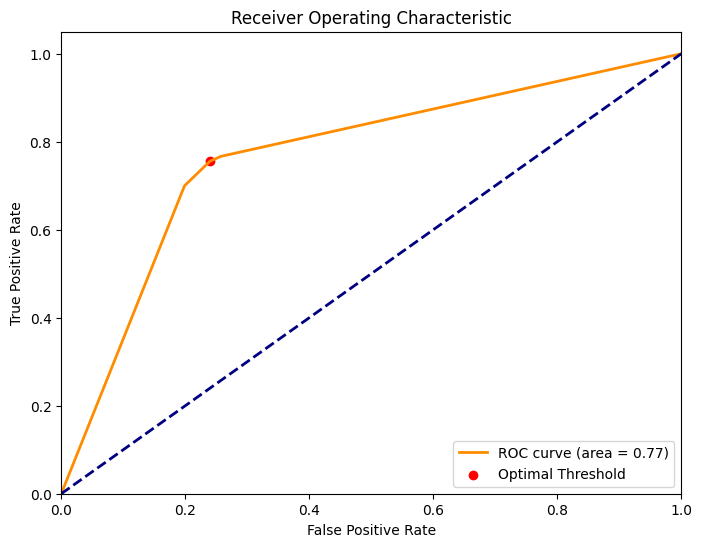

AUC: 0.77
Optimal Threshold: 0.50


In [29]:
# Compute the predicted probabilities of class 1 for the test set
y_pred_prob = optimized_tree.predict_proba(X_test)[:, 1]

# Compute TPR and FPR for various threshold settings
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the AUC
roc_auc = auc(fpr, tpr)

# Calculate the optimal threshold (the one closest to the top-left corner of the ROC space)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Optimal Threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print the AUC and the optimal threshold
print('AUC: %0.2f' % roc_auc)
print('Optimal Threshold: %0.2f' % optimal_threshold)

In [37]:
#mise en place des nouvelles valuers de X
X_train=pca.transform(X_train_scaled)[:, :10]
X_test=pca.transform(X_test_scaled)[:, :10]

In [38]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 100,9),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5),
    'ccp_alpha': [0,0.00001,0.0001,0.001]  # Add a range for ccp_alpha
}


# Initialize the GridSearchCV object with cross-validation
grid_search = GridSearchCV


# Initialize the GridSearchCV object with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1234), param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# The best hyperparameters from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 2816 candidates, totalling 14080 fits


In [39]:
# Train the model with the best hyperparameters
optimized_tree = grid_search.best_estimator_

# Predict on the test set with the optimized model
y_pred_optimized = optimized_tree.predict(X_test)

# A. Detailed Accuracy By Class
# Calculate the accuracy with the optimized model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
classification_rep_optimized = classification_report(y_test, y_pred_optimized)

print(best_params, best_score, accuracy_optimized, classification_rep_optimized)

# B. Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_optimized)

# C. Additional metrics
# Precision, recall, and f1-scores for each class
precision_class_0 = precision_score(y_test, y_pred_optimized, pos_label=0)
precision_class_1 = precision_score(y_test, y_pred_optimized, pos_label=1)
recall_class_0 = recall_score(y_test, y_pred_optimized, pos_label=0)
recall_class_1 = recall_score(y_test, y_pred_optimized, pos_label=1)
f1_score_class_0 = f1_score(y_test, y_pred_optimized, pos_label=0)
f1_score_class_1 = f1_score(y_test, y_pred_optimized, pos_label=1)

# Compile all the additional metrics into a dictionary for presentation
additional_metrics = {
    'Precision Class 0': precision_class_0,
    'Precision Class 1': precision_class_1,
    'Recall Class 0': recall_class_0,
    'Recall Class 1': recall_class_1,
    'F1 Score Class 0': f1_score_class_0,
    'F1 Score Class 1': f1_score_class_1,
}

print(conf_mat)
print(additional_metrics)

{'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6} 0.9318230358504958 0.9233716475095786               precision    recall  f1-score   support

           0       0.96      0.92      0.94       171
           1       0.86      0.92      0.89        90

    accuracy                           0.92       261
   macro avg       0.91      0.92      0.92       261
weighted avg       0.93      0.92      0.92       261

[[158  13]
 [  7  83]]
{'Precision Class 0': 0.9575757575757575, 'Precision Class 1': 0.8645833333333334, 'Recall Class 0': 0.9239766081871345, 'Recall Class 1': 0.9222222222222223, 'F1 Score Class 0': 0.9404761904761904, 'F1 Score Class 1': 0.89247311827957}


Ici, on retrouve des résultats plus proche de ceux observés avec l'arbre de décision, supérieurs à 90%. Ce modèle est donc plus efficace que l'AFD utilisée en 5a, et permet de se rapprocher de l'efficacité d'un arbre de décision. 

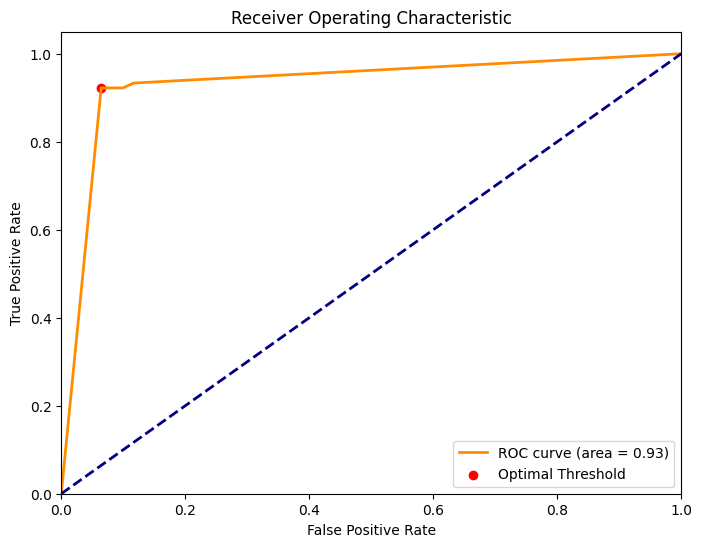

AUC: 0.93
Optimal Threshold: 1.00


In [40]:
# Compute the predicted probabilities of class 1 for the test set
y_pred_prob = optimized_tree.predict_proba(X_test)[:, 1]

# Compute TPR and FPR for various threshold settings
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the AUC
roc_auc = auc(fpr, tpr)

# Calculate the optimal threshold (the one closest to the top-left corner of the ROC space)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Optimal Threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print the AUC and the optimal threshold
print('AUC: %0.2f' % roc_auc)
print('Optimal Threshold: %0.2f' % optimal_threshold)

In [41]:
# Obtenez les probabilités prédites de la classe 1 pour l'ensemble de test
y_pred_prob = optimized_tree.predict_proba(X_test)[:, 1]

# Appliquez le seuil optimal pour déterminer les nouvelles étiquettes de classe prédites
y_pred_optimized_threshold = (y_pred_prob >= optimal_threshold).astype(int)
# Recalculez les métriques de performance avec les nouvelles prédictions
accuracy_optimized_threshold = accuracy_score(y_test, y_pred_optimized_threshold)
classification_rep_optimized_threshold = classification_report(y_test, y_pred_optimized_threshold)

# Matrice de confusion mise à jour
conf_mat_optimized_threshold = confusion_matrix(y_test, y_pred_optimized_threshold)

# Métriques supplémentaires mises à jour
precision_class_0_optimized_threshold = precision_score(y_test, y_pred_optimized_threshold, pos_label=0)
precision_class_1_optimized_threshold = precision_score(y_test, y_pred_optimized_threshold, pos_label=1)
recall_class_0_optimized_threshold = recall_score(y_test, y_pred_optimized_threshold, pos_label=0)
recall_class_1_optimized_threshold = recall_score(y_test, y_pred_optimized_threshold, pos_label=1)
f1_score_class_0_optimized_threshold = f1_score(y_test, y_pred_optimized_threshold, pos_label=0)
f1_score_class_1_optimized_threshold = f1_score(y_test, y_pred_optimized_threshold, pos_label=1)

# Recalculate the F1 score with the new threshold
f1_score_optimized_threshold = f1_score(y_test, y_pred_optimized_threshold)

# Display the F1 score with the optimal threshold
print("F1 Score with optimal threshold:", f1_score_optimized_threshold)
# Compilez toutes les métriques supplémentaires dans un dictionnaire pour la présentation
additional_metrics_optimized_threshold = {
    'Precision Class 0': precision_class_0_optimized_threshold,
    'Precision Class 1': precision_class_1_optimized_threshold,
    'Recall Class 0': recall_class_0_optimized_threshold,
    'Recall Class 1': recall_class_1_optimized_threshold,
    'F1 Score Class 0': f1_score_class_0_optimized_threshold,
    'F1 Score Class 1': f1_score_class_1_optimized_threshold,
}

# Afficher les résultats
print("Meilleurs paramètres:", best_params)
print("F1 Score with optimal threshold:", f1_score_optimized_threshold)
print("Précision avec seuil optimal:", accuracy_optimized_threshold)
print("Rapport de classification avec seuil optimal:", classification_rep_optimized_threshold)
print("Matrice de confusion avec seuil optimal:", conf_mat_optimized_threshold)
print("Métriques supplémentaires avec seuil optimal:", additional_metrics_optimized_threshold)

F1 Score with optimal threshold: 0.9021739130434783
Meilleurs paramètres: {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6}
F1 Score with optimal threshold: 0.9021739130434783
Précision avec seuil optimal: 0.9310344827586207
Rapport de classification avec seuil optimal:               precision    recall  f1-score   support

           0       0.96      0.94      0.95       171
           1       0.88      0.92      0.90        90

    accuracy                           0.93       261
   macro avg       0.92      0.93      0.92       261
weighted avg       0.93      0.93      0.93       261

Matrice de confusion avec seuil optimal: [[160  11]
 [  7  83]]
Métriques supplémentaires avec seuil optimal: {'Precision Class 0': 0.9580838323353293, 'Precision Class 1': 0.8829787234042553, 'Recall Class 0': 0.935672514619883, 'Recall Class 1': 0.9222222222222223, 'F1 Score Class 0': 0.9467455621301775, 'F1 Score Class 1': 0.9021739130434783}

En optimisant nos paramètres, on arrive finalement à quelque chose de très proche de l'arbre de décision. 

En conclusion, l'utilisation conjointe de l'ACP et l'AFD permet d'améliorer l'efficacité du modèle, et d'obtenir des résultats équivalents à ceux d'un arbre de décision tel que celui utilisé plus tôt dans ce sujet.  